In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import*

## Pauli matrices

In [2]:
I2 = np.matrix([[1,0],
                [0,1]])
H  = np.matrix([[1,1],
                [1,-1]])* (1/np.sqrt(2))
S  = np.matrix([[1,0],
                [0,1j]])
X  = np.matrix([[0,1],
                [1,0]])
Y  = np.matrix([[0,-1j],
                [1j,0]])
Z  = np.matrix([[1,0],
                [0,-1]])

In [3]:
def commutator(matrix_a,matrix_b):
    return matrix_a@matrix_b - matrix_b@matrix_a
def anti_commutator(matrix_a,matrix_b):
    return matrix_a@matrix_b + matrix_b@matrix_a

In [4]:
large = 40; med = 34; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)

In [5]:
r"""
# parameters of Hamiltonians and Lindbladians
b       = 0.1
gamma_1 = 0.02
gamma_2 = 0.05

I2 = pauli_list[0]
X = pauli_list[1]
Y = pauli_list[2]
Z = pauli_list[3]
Hamiltonian = (-b/2)*X
L_1 = np.sqrt(gamma_1)*np.matrix([[0,1],[1,0]])
L_2 = np.sqrt(gamma_2)*Z

# steady state density matrix parameters
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss   = (2*b*gamma_1)/Delta
zss   = (gamma_1*(gamma_1+4*gamma_2))/Delta

# steady state density matrix
rho_ss = (1/2)*(I2+yss*Y+zss*Z)

# angles for steady state preparation
theta_x = np.arccos(zss)
theta_y = np.arccos(-yss/(4*np.sqrt(1+zss**2)))""";

## Variation of parameters

In [6]:
N_qubit = 2
# returns N*K classical shadows.
def classical_shadow_using_ST(N,K,theta_x,theta_y,theta_z,theta_ry):
    
    # setting up the quantum circuit
    qc = QuantumCircuit(N_qubit)
    # initializing the ancilla qubit at |0>.
    qc.initialize([1,0],0)
    qc.rx(theta_x,1)
    qc.ry(theta_y,1)
    qc.rz(theta_z,1)
    qc.cry(theta_ry,1,0)
    sv = np.matrix(Statevector.from_instruction(qc)).conj().T
    rho_SS = sv@(sv.conj().T)   

    # number of shadows
    nShadows = N*K
    # number of shots
    number_of_shots = 1
    rng = np.random.default_rng(1000)
    cliffords = [qiskit.quantum_info.random_clifford(N_qubit,seed = rng) for _ in range(nShadows)]    
    results = []    
    for cliff in cliffords:
        qc_c  = qc.compose(cliff.to_circuit())
        # samples the output in computational basis.
        counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(number_of_shots)
        results.append(counts)  
    
    # performing rho_hat = (2**N+1)*(U^{\dagger}|b><b|U-I).
    shadow_lst = []
    # loops over the clifford gates and their corresponding measurement results.
    for cliff, res in zip(cliffords, results):
        # U^{\dagger} matrix.
        mat    = cliff.adjoint().to_matrix()
        for bit,count in res.items():
            Ub = mat[:,int(bit,2)] # this is Udag|b>
            shadow_lst.append(((2**N_qubit+1.))*np.outer(Ub,Ub.conj())*count - np.eye(2**N_qubit))    
    return rho_SS, shadow_lst

#qc.draw("mpl", scale=3,style="clifford")

## Shadow tomography

In [7]:
b = 0.2
gamma_1 = 0.1
gamma_2 = 0.9

# known analytical solution
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss= (2*b*gamma_1)/Delta
zss = (gamma_1*(gamma_1+4*gamma_2))/Delta

theta_y_exact = np.pi/8
theta_x_exact = np.arccos(zss/np.cos(theta_y_exact))
theta_z_exact = np.arctan(-np.sin(theta_y_exact)/np.tan(theta_x_exact))
theta_ry_exact = 2*np.arccos(-yss*np.cos(theta_z_exact)/np.sin(theta_x_exact))

print("theta_z = ",theta_z_exact)
print("theta_x = ",theta_x_exact)
print("theta_y = ",theta_y_exact)
print("theta_ry = ",theta_ry_exact)

theta_z =  -0.6414725691602342
theta_x =  0.4735237017488994
theta_y =  0.39269908169872414
theta_ry =  3.4552240242785945


In [8]:
M = 1
2*np.log(2*M/0.01)

10.596634733096073

## Comparison of exact and shadow density matrix

In [9]:
r"""
N = 50
K = 10
exact_and_shadow_density_matrix = classical_shadow_using_ST(N,K,theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)
rho_exact = exact_and_shadow_density_matrix[0]
rho_shadow_lst = exact_and_shadow_density_matrix[1]
# average classical shadow.
rho_shadow = np.sum(rho_shadow_lst,axis=0)/(len(rho_shadow_lst))""";

In [10]:
r"""
large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
plt.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)

c1 = axs[0, 0].imshow(rho_exact.real)
axs[0, 0].set_title(r"Exact Re$[\rho]$")

c2 = axs[0, 1].imshow(rho_shadow.real)
axs[0, 1].set_title(r"Shadow Re$[\rho]$")

c3 = axs[1, 0].imshow(rho_exact.imag)
axs[1, 0].set_title(r"Exact Im$[\rho]$")

c4 = axs[1, 1].imshow(rho_shadow.imag)
axs[1, 1].set_title(r"Shadow Im$[\rho]$")

plt.suptitle("N = "+str(len(rho_shadow_lst)))

#for ax in axs.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(c4, cax=cax, orientation='vertical')

# Display the figure with subplots
plt.tight_layout()    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
plt.savefig("density_matrix_comparison_"+str(len(rho_shadow_lst))+".jpg", dpi=600)
plt.show()""";

In [11]:
def quadratic_o_i_k(N,k,Operator_1, Operator_2):
    s = 0.0
    for j in range(N*(k-1)+1,N*k+1):
        for l in range(N*(k-1)+1,N*k+1):
            if j != l:
                rho_j = set_of_shadows[j]
                rho_l = set_of_shadows[l]
                s += np.trace(np.kron(Operator_1,I2)@rho_j@np.kron(Operator_2,I2)@rho_l)
    return (1/(N*(N-1)))*s
def linear_o_i_k(N,k,Operator):
    s = 0.0
    for j in range(N*(k-1)+1,N*k+1):
        rho_j = set_of_shadows[j]
        s += np.trace(Operator@rho_j)
    return s/N

## Lindblad equation

In [12]:
r"""

this function returns \mathcal{L}\rho i.e. the right hand side of the
Lindblad equation.

input: density matrix (either exact or shadow), list of Lindbladians.
output: right hand side of the Lindblad equation.

"""

def partial_trace(mat):
    return np.matrix([[mat[0,0]+mat[1,1],mat[0,2]+mat[1,3]],
                      [mat[2,0]+mat[3,1],mat[2,2]+mat[3,3]]])

# the parameter that should be changed is the density_mat
def lindblad_equation(density_mat, hamiltonian, L_1, L_2):
    # reduced density matrix for the state
    #rho_state = partial_trace(density_mat)
    return (-1j*commutator(hamiltonian,density_mat)
            + L_1@density_mat@(L_1.conj().T) - (1/2)*anti_commutator((L_1.conj().T)@L_1,density_mat)
            + L_2@density_mat@(L_2.conj().T) - (1/2)*anti_commutator((L_2.conj().T)@L_2,density_mat))

#M = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
#partial_trace(M)

## Parameters and angles

In [13]:
# density matrix in terms of angles
def rho_SS_from_angles(theta_x,theta_y,theta_z,theta_ry):
    rho_11 = (1/2)*(1+np.cos(theta_x)*np.cos(theta_y))
    rho_12 = ((1/2)*np.exp(-1j*theta_z)*np.cos(theta_ry/2)*(np.sin(theta_y)*np.cos(theta_x)
                                                           +1j*np.sin(theta_x)))
    return np.matrix([[rho_11,rho_12],[rho_12.conj(),1-rho_11]])

rho_SS_exact = (1/2)*(I2+yss*Y+zss*Z)
rho_SS_exact

matrix([[0.91111111+0.j        , 0.        -0.04444444j],
        [0.        +0.04444444j, 0.08888889+0.j        ]])

In [14]:
rho_SS_from_angles(theta_x_exact,theta_y_exact,theta_z_exact,theta_ry_exact)

matrix([[ 9.11111111e-01+0.j        , -6.93889390e-18-0.04444444j],
        [-6.93889390e-18+0.04444444j,  8.88888889e-02+0.j        ]])

In [15]:
lindblad_equation(rho_SS_exact,-(b/2)*X,np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),np.sqrt(gamma_2)*Z)

matrix([[0.00000000e+00+0.j, 0.00000000e+00+0.j],
        [0.00000000e+00+0.j, 1.38777878e-17+0.j]])

In [16]:
print("theta_z  = ",theta_z_exact)
print("theta_x  = ",theta_x_exact)
print("theta_y  = ",theta_y_exact)
print("theta_ry = ",theta_ry_exact)

theta_z  =  -0.6414725691602342
theta_x  =  0.4735237017488994
theta_y  =  0.39269908169872414
theta_ry =  3.4552240242785945


In [35]:
rho_SS_angles = rho_SS_from_angles(-1,theta_y_exact,theta_z_exact,theta_ry_exact)
cost_function(lindblad_equation(rho_SS_angles,-(b/2)*X,np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),np.sqrt(gamma_2)*Z))

(0.05446253953499142+0j)

In [21]:
divisons = 20
theta_x_lst = np.linspace(-1,1,divisons)

def cost_function(rho):
    return np.trace(rho@rho)

exact_rho_lst  = []
shadow_rho_lst = []

cost_function_array_shadow = np.zeros(divisons)
cost_function_array_exact= np.zeros(divisons)
N = 50
K = 10
for xx in range(divisons):
            ST = classical_shadow_using_ST(N,K,theta_x_lst[xx],
                                               theta_y_exact,
                                               theta_z_exact,
                                               theta_ry_exact)
            rho_exact = ST[0]
            #exact_rho_lst.append(rho_exact)
            rho_shadow_lst = ST[1]
            rho_shadow  = np.sum(rho_shadow_lst,axis=0)/(len(rho_shadow_lst))
            #shadow_rho_lst.append(partial_trace(rho_shadow))
            
            Liouv_rho_exact= lindblad_equation(partial_trace(rho_exact),-(b/2)*X,
                                                 np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),
                                                 np.sqrt(gamma_2)*Z)            
            Liouv_rho_shadow = lindblad_equation(partial_trace(rho_shadow),-(b/2)*X,
                                                 np.sqrt(gamma_1)*np.matrix([[0,1],[0,0]]),
                                                 np.sqrt(gamma_2)*Z)
            
            cost_function_array_exact[xx] = cost_function(Liouv_rho_exact).real
            cost_function_array_shadow[xx] = cost_function(Liouv_rho_shadow).real 

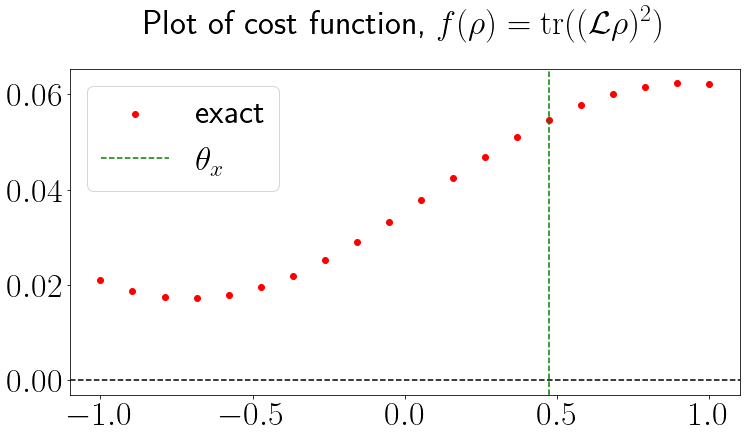

In [18]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
plt.scatter(theta_x_lst,cost_function_array_exact,c="red",label=r"exact")
#plt.plot(theta_x_lst,cost_function_array_shadow,c="blue")
#plt.scatter(theta_x_lst,cost_function_array_shadow,c="blue",label=r"shadow")

ax = f.gca()
ax.axvline(theta_x_exact, color="green",label = r"$\theta_{x}$",linestyle="--")
ax.axhline(0, color="k",linestyle="--")
#ax.axvline(-np.pi+theta_x_exact, color="green",label = r"$\theta_{x}$",linestyle="--")
plt.title("Plot of cost function, "+r"$f( \rho ) = \textrm{tr}((\mathcal{L}\rho)^{2})$")
plt.legend()
plt.show()

In [19]:
r"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
large = 40; med = 34; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': small ,
          'ytick.labelsize': small ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
# Create a figure
fig = plt.figure()

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

theta_x_mesh,theta_ry_mesh = np.meshgrid(theta_x_lst,theta_ry_lst)
# Plot the surface
ax.plot_surface(theta_x_mesh, theta_ry_mesh, cost_function_array,cmap='viridis',\
                edgecolor='green')
# Set labels
ax.set_xlabel(r"$\theta_{y}$")
ax.set_ylabel(r"$\theta_{ry}$")
ax.set_zlabel(r"$f(\rho)$")

fig.set_figwidth(13)
fig.set_figheight(10)
# Show the plot
ax.plot([theta_x_exact], [theta_ry_exact], [0.0], markerfacecolor='k',
        markeredgecolor='k', marker='o', markersize=5, alpha=0.6)
# Set the viewing angle
ax.view_init(elev=10, azim=20)
plt.show()""";